In [5]:
#import librabries

import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense ,Input ,Dropout , Flatten , Conv2D 
from tensorflow.keras.layers import BatchNormalization ,Activation ,MaxPooling2D
from tensorflow.keras.models import Model ,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint , ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version :" , tf.__version__)

Tensorflow version : 2.11.0


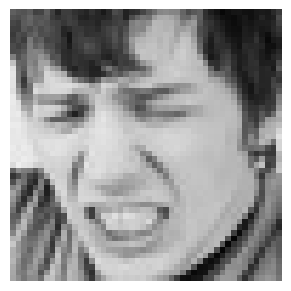

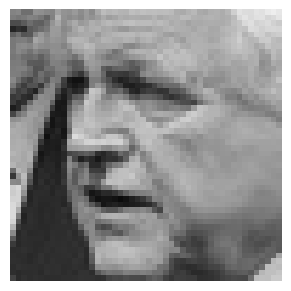

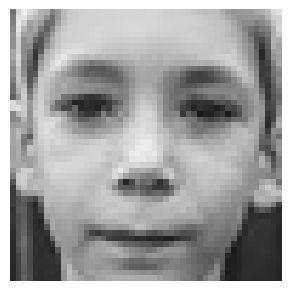

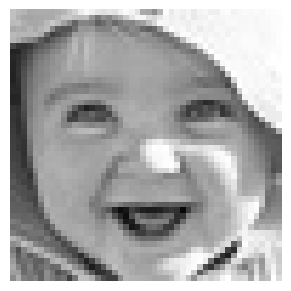

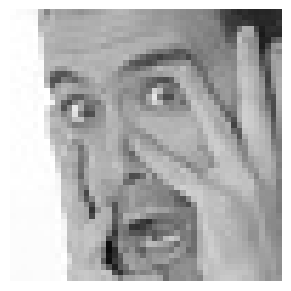

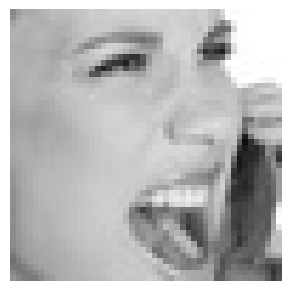

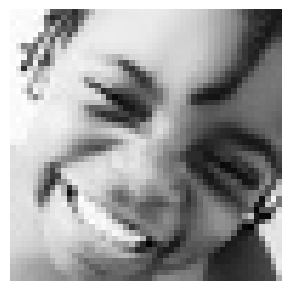

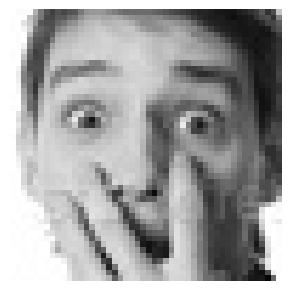

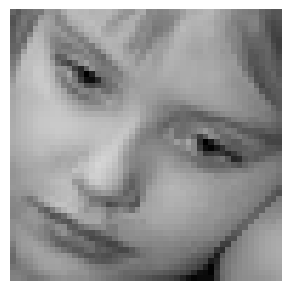

In [7]:
#explore dataset

images =glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize = (12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [8]:
img_size =48
batch_size =64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/", 
                                                    target_size = (img_size , img_size),
                                                    color_mode  ="grayscale",
                                                    batch_size =batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/", 
                                                    target_size = (img_size , img_size),
                                                    color_mode  ="grayscale",
                                                    batch_size =batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
def Convolution(input_tensor , filters , kernel_size):
    x= Conv2D(filters =filters ,kernel_size = kernel_size , padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x= MaxPooling2D(pool_size = (2,2))(x)
    x= Dropout(0.25)(x)
    return x

In [10]:
def Dense_f(input_tensor ,nodes):
    x=Dense(nodes)(input_tensor)
    x= BatchNormalization()(x)
    x = Activation('relu')(x)
    x= Dropout(0.25)(x)
    return x
    

In [11]:
def model_fer(input_shape):
    inputs =Input(input_shape)
    conv_1 = Convolution(inputs ,32, (3,3))
    conv_2 = Convolution(inputs , 64, (5,5))
    conv_3 = Convolution(inputs , 128, (3,3))
    
    flatten = Flatten()(conv_3)
    dense_1 = Dense_f(flatten ,256)
    output = Dense(7,activation ="softmax")(dense_1)
    model = Model(inputs =[inputs],outputs = [output])
    model.compile(loss =['categorical_crossentropy'] , optimizer ='adam' , metrics = ['accuracy'])
    return model
    
    



In [12]:
model = model_fer((48 ,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 128)       0     

In [13]:
#initialize the model
epochs =15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5" , monitor = 'val_accuracy' , save_weights_only =True ,mode ='max' ,verbose =1)
callbacks = [checkpoint] 

In [14]:
#training model
history =model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs =epochs,
    validation_data = validation_generator,
    validation_steps =validation_steps,
    callbacks = callbacks)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.6400 - accuracy: 0.3760
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 307s 680ms/step - loss: 1.6400 - accuracy: 0.3760 - val_loss: 1.5234 - val_accuracy: 0.4014
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.3496 - accuracy: 0.4899
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 293s 654ms/step - loss: 1.3496 - accuracy: 0.4899 - val_loss: 1.8680 - val_accuracy: 0.3105
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.1921 - accuracy: 0.5534
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 305s 682ms/step - loss: 1.1921 - accuracy: 0.5534 - val_loss: 1.4347 - val_accuracy: 0.4477
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.0605 - accuracy: 0.6116
Epoch 4: saving model to model_weights.h5
448/448 [==============================] - 

In [15]:
#model evaluate
model.evaluate(validation_generator)


113/113 [==============================] - 15s 128ms/step - loss: 1.8948 - accuracy: 0.5025


[1.8947781324386597, 0.5025076866149902]

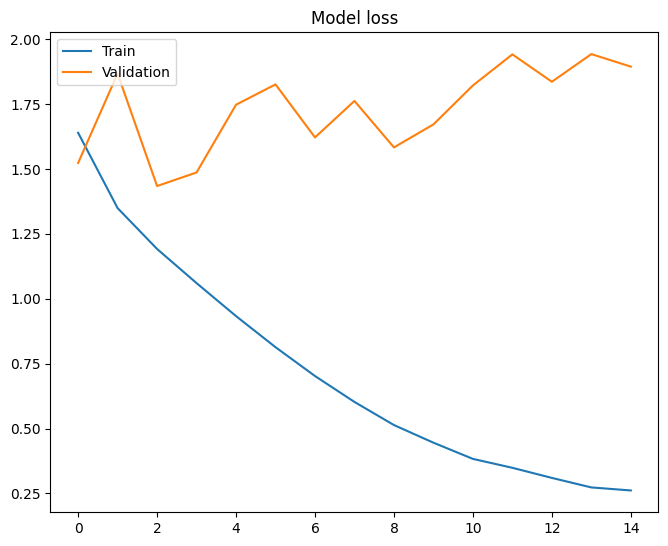

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top =1.0 , bottom = 0.0 , right = 0.95, left = 0.0 ,hspace =0.25 ,wspace =0.35)

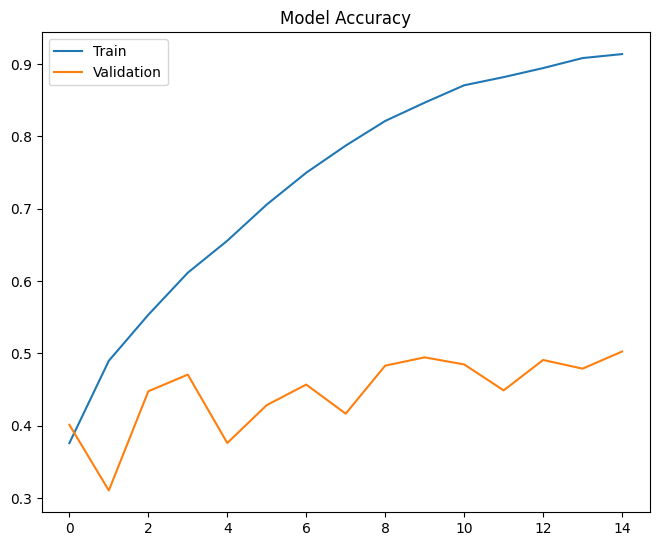

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top =1.0 , bottom = 0.0 , right = 0.95, left = 0.0 ,hspace =0.25 ,wspace =0.35)

In [20]:
#saving model
model_json = model.to_json()
with open("model_a.json","w")as json_file:
    json_file.write(model_json)
    